In [1]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 6, repr.plot.height = 4) # Change plot sizes (in cm) - this bit of code is only relevant if you are using a juyter notebook - ignore otherwise

# Generalised Linear Models

```{admonition} Learning goals
**By the end of this chapter you should be able to:**
- Understand the GLM framework: error distribution (family) + link function + linear predictor
- Fit logistic regression models for binary/proportion data and interpret odds ratios
- Fit Poisson regression models for count data and recognise overdispersion
- Check GLM fit using deviance residuals, AIC, and diagnostic plots
- Generate predictions on both link and response scales with appropriate confidence intervals
- Choose appropriate error families and link functions for different biological response types
- Communicate GLM results clearly with effect plots and interpretation
```

```{admonition} Prerequisites
:class: tip
**Before starting this chapter, you should:**
- Have covered linear regression fundamentals (coefficients, inference, diagnostics) from [Basic Data Analyses and Statistics](../part-basic-stats)
- Be comfortable with R model formulas, `lm()` output interpretation, and residual diagnostics
- Have some understanding of probability distributions (binomial, Poisson) and their biological contexts
- Consider reviewing [Pre-work probability section](mqb-prework-exercises) if distributions are unfamiliar
```

## Introduction 

Aims of this chapter[^fn1-c2]:

* Develop an intuitive understanding of generalized linear models 

* Learn to fit generalized linear models to count data

This chapter will step through the analysis carefully. These are not simple analyses so you should concentrate on understanding the process and the biology and think about how to present your results.

## What is a GLM?

Till now, we have adhered faithfully to the assumption of a normal (Gaussian) distribution for the response variable, at times transforming the response variable (e.g., by taking a log) to make it (approximately) normal. However, there are many scenarios where assuming a normal distribution for the response variable is just not appropriate, whether you transform it or not. The generalized linear model (GLM) analysis is (as the name suggests) a generalization of the ordinary linear regression model analysis to accommodate response variables that have non-normal error distributions. These types of (non-normal) response variables can arise quite commonly in the form of count (as in the practical example below) and binary response (present/absent, 0/1, etc.) data, but beyond that, many measures of interest in biology are just not normally distributed.

The GLM generalization of the ordinary Linear Models is made possible by using an (arbitrary) function of the dependent variable (the link function) that makes it vary *linearly* with the predicted values, thus making the problem relatively tractable statistically. We will not try to understand the mathematical underpinnings of this approach here, but instead learn through an example. 


## Some (statistical) distributions

First, it's time to revisit the idea of *statistical distributions*, which you were introduced to [previously](exp_design:Data-types-and-distributions). This is because while analyzing data using glms, one needs to decide what particular statistical distribution best represents (or captures, or "model's") that particular dataset. For example, continuous numeric data are *often* normally distributed (e.g., weights of lecturers!). On the other hand, count data are likely to be distributed according to the Poisson distribution (e.g., numbers of plant species found in a sampling plot). And all statistical distribution are actually a *family* of distributions of different shapes (e.g., can range from right-skewed to bell-shaped) and/or scales (spread) depending upon the value of their *parameters*. For example, the Gaussian distribution can have different scales depending on the variance parameter. More on distribution parameters below.   

There are actually a large number of statistical distributions [out there](https://en.wikipedia.org/wiki/List_of_probability_distributions) to choose from. But we will look at a few that glms support. Specifically, the `glm` procedure in R supports the following distribution "families": Binomial, Gaussian, Gamma, Inverse Gaussian, Poisson, Quasi, Quasi-Binomial, and Quasi-Poisson. You may want to look these up online (google it). You have already seen, [sampled from](exp_design:Sampling-from-distributions-in-r), and used the Gaussian distribution, so we won't go into it here. But let's look at three other distributions that are particularly useful in R. 

### The Poisson distribution

The Poisson distribution family is appropriate for discrete, integer valued data. You can generate "data" that are poisson-distributed by using the function `rpois(n, lambda)` in R:

[^fn1-c2]: (See footnote definition below.)


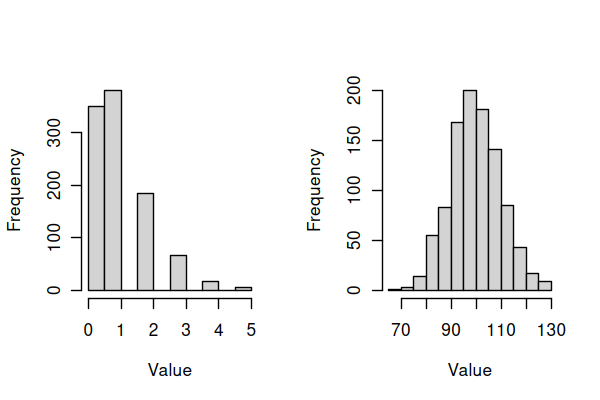

In [2]:
par(mfrow=c(1,2)) 
hist(rpois(1000, lambda = 1),xlab = "Value", main="")
hist(rpois(1000, lambda = 100),xlab = "Value", main="")

The main things to note about these plots (and poisson-distributed data): 

* This distribution is appropriate for response data that can only take integer values, such as counts (technically, only for values of $\lambda \ge 1$, but this does not really concern you as far fitting glms in R is concerned).
* A single parameter $\lambda$ ("lambda") controls the shape, the scale (the range of the variable) and the location (mean value, or central tendency) of the distribution.
* Thus, this distribution can represent a variety of shapes that count data can take, from right skewed (left plot) to bell-shaped (right plot)  &ndash; these variants of shapes and scales make up the Poisson distribution "family".

$\star$ Play with the above code and generate different shapes (and inevitably, scales) of poisson-distributed data.

### The Binomial distribution

The binomial distribution is appropriate for continuous-valued data that arise from repeated trials of binary (yes/no, 0/1, head/tail, suceptible/resistant) outcomes. This distribution is also the basis for the [binomial statistical test](https://en.wikipedia.org/wiki/Binomial_test). You can generate  binomial-distributed "data" by using the function `rbinom(n, size, prob)` in R:

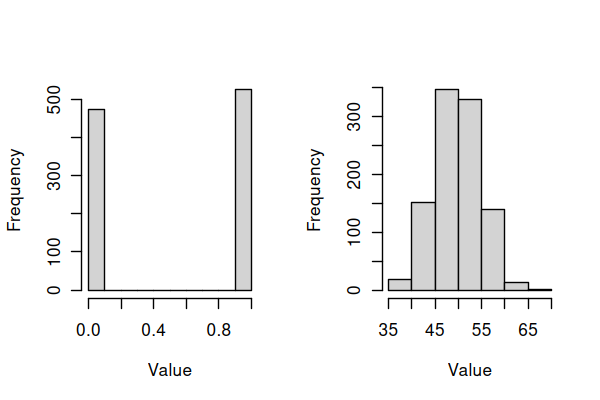

In [3]:
par(mfrow=c(1,2)) 
hist(rbinom(1000, 1, 0.5),xlab = "Value", main="")
hist(rbinom(1000, 100, 0.5),xlab = "Value", main="")

The main things to note about these plots (and Binomial-distributed data):

* The two main parameters of interest are `size` (number of trials), and `prob` (the probability of an outcome in each trial). So, 
  * The left plot is the distribution of outcomes of a single try of a 50:50 (0.5 probability, like a coin-flip) outcome, re-generated 1000 times (e.g., a thousand coin flips) &ndash; as expected, there are about 500 each of 0's and 1's (e.g., 0 = head, 1 = tail). Each of the 1000 such success/failure experiments is called a Bernoulli trial/experiment. For repeated experiments of a single trial, i.e., `size` = 1 in the R code above, the binomial distribution is a Bernoulli distribution (so the left plot is a bernoulli distribution). 
  * The right plot is the binomial distribution that you will encounter more often, which is appropriate for modeling the number of successes in a sample of a given size. In the above code, `size` = 100, with 1000 repetitions of this "experiment"). Thus in the right plot, the distribution will on average have a mean value of 50 ($0.5\times100$ trials) (recall the [Central Limit Theorem](exp_design:Data-types-and-distributions)).
* Thus, the binomial distribution family is appropriate for binomial [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), which is a GLM analysis where your sample of binary (yes/no, 0/1, etc) outcomes is fitted as a function of one or more continuous or categorical predictors.

$\star$ Play with the above code and generate variants of binomial-distributed data distributions. They will all be bell-shaped, but can take different mean and spread values.


### The Gamma distribution

The Gamma family is suitable for data that are continuous and can only take values greater than zero (positive values). Another key feature of this distribution family is that the ratio of its variance and mean is constant, so it is appropriate to model data where increasing a mean value also increases the variance as a fixed (constant) factor.  Because of this property, the Gamma family is often used to fit a GLM to response variables that are times, such as waiting time, time between failure, or inverse of the rate of any event, such as an accident.

You can generate  Gamma-distributed "data" by using the function `rgamma(n, shape, rate)` in R:

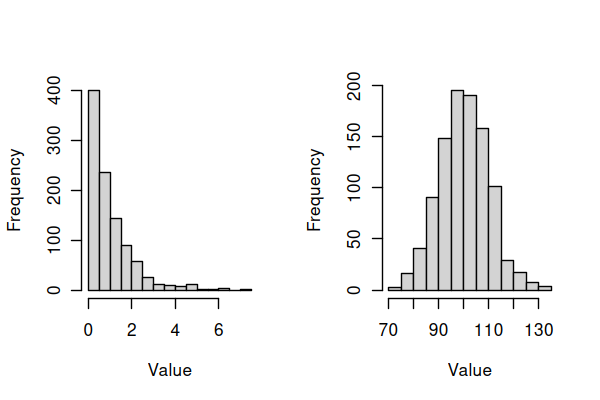

In [4]:
par(mfrow=c(1,2)) 
hist(rgamma(1000,1,1),xlab = "Value", main = "")
hist(rgamma(1000,100,1),xlab = "Value", main = "")

The main things to note about these plots (and Gamma-distributed data):
* The main parameters of interest are the `shape` and `rate`. The latter controls the distribution's scale (over what values the distributions spreads).
* This distribution can be right-skewed or bell-shaped, depending on choice of the `shape` parameter.

$\star$ Play with the above code and generate variants in the gamma-distributed data family.

### Other distributions

There are also the Quasi-binomial and Quasi-poisson families within R's `glm` procedure, which differ from the Binomial and Poisson families in that the dispersion parameter (variance to mean ratio) is not fixed at one, so that over-dispersion in your data (greater variability than would be expected based on the given statistical model) can be modeled. You will see an example of this below. 

Thus, the first and key step while using glms is to determine what type of distribution best describes your response variable. We will now try put this and subsequent steps of fitting glms.  

## A GLM example

We will use mutation data collected in the Genetics Practical by a previous year's batch. 

The students were basically counting colonies looking for mutations. There were a number of bacterial strains which were different mutants of *Salmonella*. Each group applied a mutagen Nitroguanisine (NG) as well as histidine and streptomycine. A control plate was also tested.

The data file is called `prac_data.csv` (so it's a comma-separated values file), and is available from TheMulQuaBio's  `data` directory.

$\star$ Save the `prac_data.csv` dataset into your `data` directory.

$\star$ Create a new script called MyGLM.R in your `code` directory. Use the code below to load and check your data.

$\star$ Start r and change the working directory to `code`, and read in the data:

In [5]:
colonies <- read.csv("../data/prac_data.csv", stringsAsFactors = T)
str(colonies)
head(colonies)

'data.frame':	680 obs. of  5 variables:
 $ Student.ID : Factor w/ 34 levels "A1","A10","A11",..: 1 1 1 2 2 2 4 4 4 4 ...
 $ Strain     : Factor w/ 5 levels "421","712","881",..: 4 3 5 1 2 3 4 2 3 5 ...
 $ Treatment  : Factor w/ 4 levels "Control","His",..: 1 1 1 3 3 1 1 3 3 1 ...
 $ ColonyCount: int  0 0 0 0 0 0 0 0 0 0 ...
 $ HaloLawn   : Factor w/ 2 levels "N","Y": NA NA NA NA NA NA NA NA NA NA ...


,Student.ID,Strain,Treatment,ColonyCount,HaloLawn
,<fct>,<fct>,<fct>,<int>,<fct>
1,A1,899,Control,0,NA
2,A1,881,Control,0,NA
3,A1,TA102,Control,0,NA
4,A10,421,NG,0,NA
5,A10,712,NG,0,NA
6,A10,881,Control,0,NA


Now let's explore the data first.

### Data exploration

We have a continuous response variable (`ColonyCount`) and two categorical explanatory variables (`Strain` and `Treatment`). We also have observations of halos and bacterial lawns around the treated areas (`HaloLawn`), which we will come back to at the end of this chapter.

So, with two factors as the explanatory variables, we will use box and whisker plots and boxplots to explore the data. First, we'll look at the effects of the four treatments.

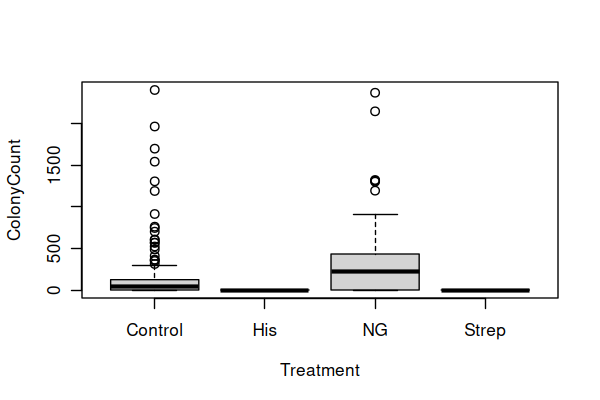

In [6]:
boxplot(ColonyCount ~ Treatment, data=colonies)

There are two immediate things to note.

(1) The distributions of colony counts are very *skewed* — many small counts and a few large counts. We've already seen that taking a log of data sometimes works in these cases. However, as the tables above show, we have zero counts for all treatments and $\log(0)$ is undefined. A common trick is therefore to use $\log(n+1)$ (add 1 and take a log) when dealing with count data like this:

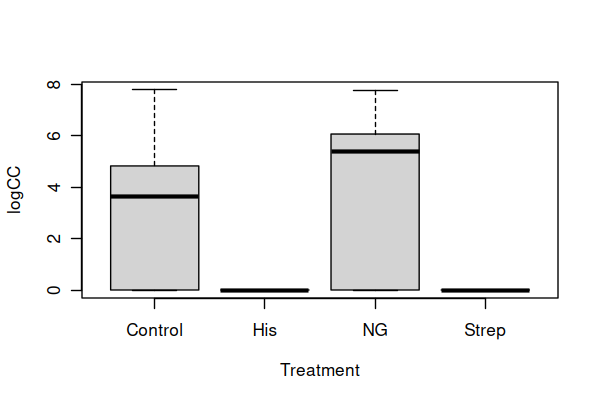

In [7]:
colonies$logCC <- log(colonies$ColonyCount + 1)
boxplot(logCC ~ Treatment, data=colonies)

I hope you'll agree that this still doesn't look very convincingly like normal data, but we'll come back to this point.

(2)  The colony counts are vastly different between the different treatments. It is hard to say for sure from the two plots, but it looks like colonies never grow under the histidine and streptomycine treatments. We can check that:

In [12]:
tapply(colonies$ColonyCount, colonies$Treatment, min, na.rm = TRUE)

Control     His      NG   Strep 
      0       0       0       0

In [13]:
tapply(colonies$ColonyCount, colonies$Treatment, max, na.rm = TRUE)

Control     His      NG   Strep 
   2400       0    2367       0

There is indeed no variation at all in colony count for histidine and streptomycine — colonies never grow in these treatments. We don't really need statistics for this observation and, in fact, variation is needed for statistics to work. So, for the rest of this analysis, we will reduce the dataset to the control and nitroguanisine treatments.

$\star$ Update your script by including the code for these plots.

We'll use a new piece of code here to get the right subset. `var %in% c('a','b','c')` finds all the entries in `var` whose values are equal to `'a'`, `'b'` Or `'c'`.

This is new syntax, so let's make sure we understand it. For example, try the following:

In [14]:
MyData1 <- rep(c("Control", "NG", "NG"), 4)
MyData1

[1] "Control" "NG"      "NG"      "Control" "NG"      "NG"      "Control"
 [8] "NG"      "NG"      "Control" "NG"      "NG"

In [15]:
MyData1 %in% c("Control", "NG")

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

This is the same as doing:

In [16]:
 MyData1 == "Control" |  MyData1 == "NG"

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

Note that this is NOT the same as doing:

In [17]:
MyData1 == c("Control", "NG")

[1]  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE

This is because concatenating the variable names `"Control"` and  `"NG"` using `c()` forces r to match only pairs in that sequence, and not just that, but also only search in successive blocks of two entries. That is why above, the sub-sequence `'Control' 'NG' 'NG' 'Control' 'NG'` still returns `TRUE TRUE FALSE FALSE FALSE`, as the second occurrence of the pair `'Control' 'NG'` comes in an odd location, following a single `'NG'`.  

Now, let's do the subsetting using `%in%`: 

In [18]:
coloniesCN <- subset(colonies, Treatment %in% c("Control", "NG"))
str(coloniesCN)

'data.frame':	340 obs. of  6 variables:
 $ Student.ID : Factor w/ 34 levels "A1","A10","A11",..: 1 1 1 2 2 2 4 4 4 4 ...
 $ Strain     : Factor w/ 5 levels "421","712","881",..: 4 3 5 1 2 3 4 2 3 5 ...
 $ Treatment  : Factor w/ 4 levels "Control","His",..: 1 1 1 3 3 1 1 3 3 1 ...
 $ ColonyCount: int  0 0 0 0 0 0 0 0 0 0 ...
 $ HaloLawn   : Factor w/ 2 levels "N","Y": NA NA NA NA NA NA NA NA NA NA ...
 $ logCC      : num  0 0 0 0 0 0 0 0 0 0 ...


Note that this is the same as doing:

In [19]:
coloniesCN <- subset(colonies, Treatment == "Control" | Treatment == "NG")
str(coloniesCN)

'data.frame':	340 obs. of  6 variables:
 $ Student.ID : Factor w/ 34 levels "A1","A10","A11",..: 1 1 1 2 2 2 4 4 4 4 ...
 $ Strain     : Factor w/ 5 levels "421","712","881",..: 4 3 5 1 2 3 4 2 3 5 ...
 $ Treatment  : Factor w/ 4 levels "Control","His",..: 1 1 1 3 3 1 1 3 3 1 ...
 $ ColonyCount: int  0 0 0 0 0 0 0 0 0 0 ...
 $ HaloLawn   : Factor w/ 2 levels "N","Y": NA NA NA NA NA NA NA NA NA NA ...
 $ logCC      : num  0 0 0 0 0 0 0 0 0 0 ...


You'll see that, although we have removed two treatments, their names still appear in the list of levels in the `str` output. r retains a list of all the levels that were originally in a factor, even when those levels aren't used any more. This will be annoying later, so
we'll use the `droplevels` function to strip them out.

In [20]:
coloniesCN <- droplevels(coloniesCN)
str(coloniesCN)

'data.frame':	340 obs. of  6 variables:
 $ Student.ID : Factor w/ 34 levels "A1","A10","A11",..: 1 1 1 2 2 2 4 4 4 4 ...
 $ Strain     : Factor w/ 5 levels "421","712","881",..: 4 3 5 1 2 3 4 2 3 5 ...
 $ Treatment  : Factor w/ 2 levels "Control","NG": 1 1 1 2 2 1 1 2 2 1 ...
 $ ColonyCount: int  0 0 0 0 0 0 0 0 0 0 ...
 $ HaloLawn   : Factor w/ 0 levels: NA NA NA NA NA NA NA NA NA NA ...
 $ logCC      : num  0 0 0 0 0 0 0 0 0 0 ...


$\star$ Add these commands for sub-setting your data to your script file.

### Looking at strains too

Now we'll look to see how counts differ between the strains. A quick and elegant way to visualise this is to use the `ggplot2` package to get plots grouped by treatment.

In [21]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 6, repr.plot.height = 4) # Change plot size

Warning message:
“Removed 46 rows containing non-finite values (`stat_boxplot()`).”


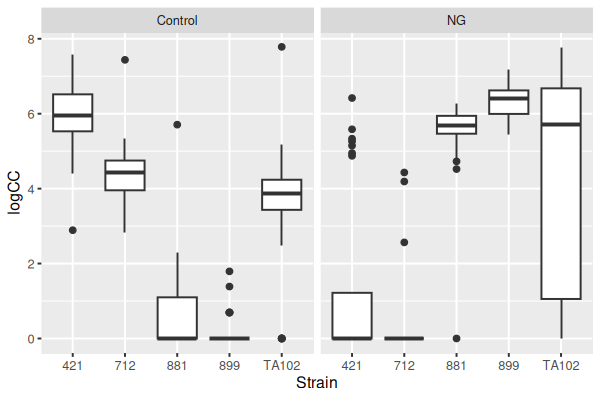

In [22]:
library(ggplot2)
ggplot(coloniesCN, aes(x = Strain, y= logCC)) + 
    geom_boxplot() + facet_grid(. ~ Treatment)

First impressions from this figure:

1. The strains are doing *very* different things under the two treatments. Hopefully this now leaps out at you as suggesting that the two variables (Strain and Treatment) are *interacting*.

2. The distributions are still pretty ugly — the variances differ hugely between combinations and four combinations have a median of zero.

We can also use a barplot of means here. We'll use the original data to get the means, but can use a log scale on the $y$ axis (`log = 'y'`). 

Let's do it:

In [29]:
tab <- tapply(coloniesCN$ColonyCount, list(coloniesCN$Treatment, coloniesCN$Strain), mean, na.rm=TRUE)

print(tab)

              421        712       881     899    TA102
Control 538.20000 138.866667  12.73077   0.375 126.6875
NG       61.28571   5.517241 292.71429 593.000 523.9000


And then,

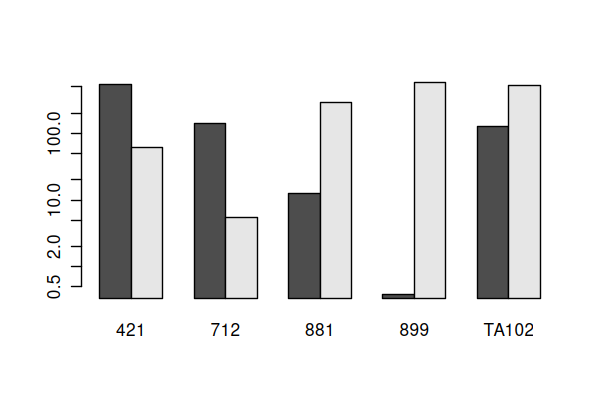

In [30]:
barplot(tab, beside=TRUE, log= 'y' )    

Let's have a go at fitting an ordinary Linear model.

### A linear model

We'll fit a model of colony count as the interaction between strain and treatment and then look at the diagnostic plots. We'd do this anyway, but we're already suspicious about the variance.

In [31]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 6, repr.plot.height = 6) # Change plot size

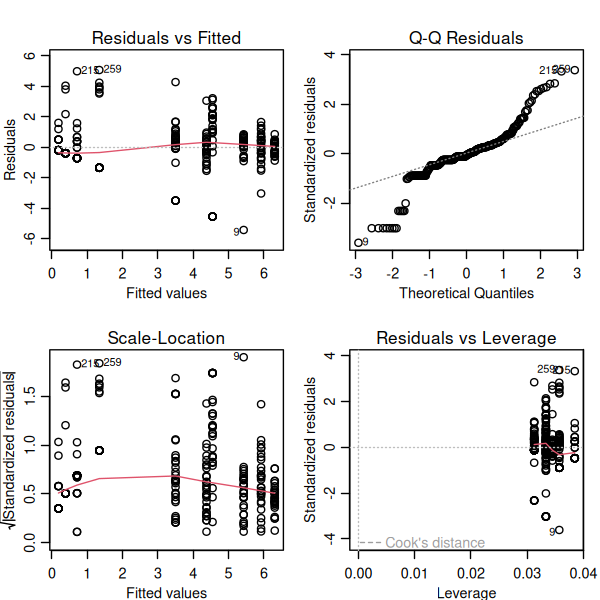

In [32]:
modLM <- lm(logCC ~ Strain * Treatment, data=coloniesCN)
par(mfrow=c(2,2), mar=c(3,3,3,1), mgp=c(2,0.8,0))
plot(modLM)

$\star$ Include run this code and have a close look at the plots.

That normal Q-Q plot is not good. Our suspicions were justified and it doesn't look like we can use a simple log transformation. We're not even going to look at the `anova` and `summary` tables — if the diagnostic plots are bad enough, then the model outputs are not
to be trusted.

## Fitting a GLM

In the linear models lecture, we looked at the expectation of *constant normal variance* in linear models. Whatever the combination of explanatory variables for a particular prediction, the residuals around that prediction have similar variance and are roughly normally distributed. The panel on the left in the figure below illustrates this basic idea.

---

<img src="./graphics/GLMexample.svg" width="700px">

<small> <br><center> Illustration of continuous data that follow a normal distribution (left) versus discrete, count data (right). </center></small>

---

As we have seen, count data do not have this distribution, even when logged. The panel on the right in the above figure shows the expected distribution of count data as the mean count increases with an explanatory variable. 

There are three key differences between the two panels of the figure:

1.  Counts can *never* be negative but can be zero.

2.  Counts are always *integers* — whole numbers — rather than being continuous.

3.  The variance of count data is *not constant*. As the average predicted count gets larger, so does the variance. Unlike the normal distribution, where variance can take any value, for count data the variance is expected to be equal to the mean.

So, we have data that are unsuitable for a linear model because they do not show constant normal variance. This is where generalised linear models come in — we can change the model for the expected residuals to use a different distribution. For count data, this is the *Poisson* distribution.

We need to change the function we use to fit models to `glm`, but otherwise the process is very similar. The whole point of the GLM is to model the original count data more appropriately, so we will abandon the logged data too. glms can cope with a range of different distributions, so we have to specify the `family` of the distribution we want to use.

So let's fit a GLM to the data:

In [33]:
modPois <- glm(ColonyCount ~ Strain * Treatment, data=coloniesCN, family= 'poisson')

First, we'll look at the summary table for this model. We have 5 levels of strain and 2 levels of factor in the subset so we get an intercept ($i$), 4 differences for strains($s_{2-5}$), one difference for treatment ($t_2$) and then four differences for the interaction ($s_{2-5}t_2$). These combine like this:

| |Control|Nitroguanisine|
|:-|:- |:- |
|421|$i$|$i+t_2$|
|712| $i + s_2$  | $i + s_2 + t_2 + s_2 t_2$  |
|881| $i + s_3$  | $i+s_3 + t_2 + s_3 t_2$ |
|889| $ + s_4$  | $i + s_4 + t_2 + s_4 t_2$  |
|TA102| $i + s_5$  | $ + s_5 + t_2  + s_5 t_2$ |


The summary table looks like this:

In [34]:
summary(modPois)


Call:
glm(formula = ColonyCount ~ Strain * Treatment, family = "poisson", 
    data = coloniesCN)

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              6.28823    0.00787  799.03   <2e-16 ***
Strain712               -1.35472    0.01738  -77.96   <2e-16 ***
Strain881               -3.74421    0.05549  -67.47   <2e-16 ***
Strain899               -7.26906    0.28878  -25.17   <2e-16 ***
StrainTA102             -1.44651    0.01757  -82.34   <2e-16 ***
TreatmentNG             -2.17268    0.02539  -85.57   <2e-16 ***
Strain712:TreatmentNG   -1.05295    0.08446  -12.47   <2e-16 ***
Strain881:TreatmentNG    5.30786    0.06152   86.28   <2e-16 ***
Strain899:TreatmentNG    9.53871    0.28989   32.91   <2e-16 ***
StrainTA102:TreatmentNG  3.59226    0.03090  116.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 134445  on 293  degrees of 

This looks similar to the `summary` table for a linear model, but with some differences. 

Let's Interpret this table: 
* Under the control treatment, strain 421 (the intercept) has the highest number of colonies and all the other strains have lower numbers to some degree — the differences are
negative. 
* The overall effect of nitrogaunasine is to decrease the number of colonies — again a negative coefficient — but then the positive interactions show big increases in colony counts for nitroguanisine for specific strains. Everything is hugely significant.
* Two types of deviance are in the model output. Deviance is a measure of goodness of fit of a GLM. The null deviance shows how well the response variable is predicted by a model that includes only the intercept (overall mean). In our example, we have a value of 134445 on 293 degrees of freedom. Including the independent variables (strain and treatment) decreased the deviance to 61579 points on 284 degrees of freedom (remember, lust like linear models, the df are decreased by the number of parameters minus 1). This is a significant reduction in deviance, so the model fit is significant.

$\star$ Copy the code in this section into your script and explore the model a bit more.

### Overdispersion

There's a problem. You may have already spotted it:

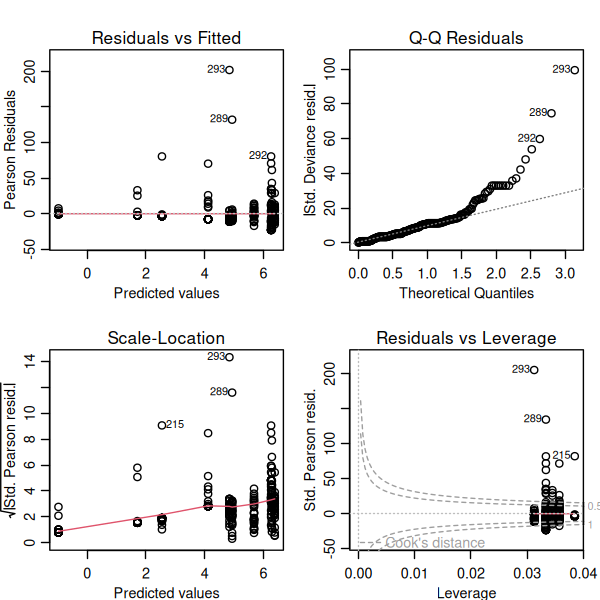

In [35]:
par(mfrow = c(2, 2), mar = c(3, 3, 3, 1), mgp = c(2, 0.8, 0))
plot(modPois)

Actually, there are two problems. First, that Q-Q plot is still a bit dubious. More of the points are close to the line than in the linear model but there are some extreme positive residuals. Second, the magnitude of the residuals is enormous, and this is really clear in the plot in the bottom right hand corner. This plot identifies outliers and any points outside of the red dotted line are possible problems.

The problem here is *overdispersion*. The Poisson distribution predicts that the variance at a point in the model is equal to the prediction — the mean count at that point. Our count data shows much more variance than this — particularly that there are some huge counts given the means.

There is a simple way to check the dispersion of count data using the `summary` table: the ratio of the residual deviance to the residual degrees of freedom should be approximately 1. This expectation is actually given in the table:

`(Dispersion parameter for poisson family taken to be 1)`

In this case, the ratio is $61579/284=216.8$. That's very strongly overdispersed. Fortunately, we can allow for this by using a different model.

### Fitting a GLM using a quasi-poisson distribution

The quasi-poisson distribution family uses the data to estimate the dispersion of the model, but is otherwise very similar to using the Poisson family. Let's re-fit the GLM using this distribution. 

In [36]:
modQPois <- glm(ColonyCount ~ Strain * Treatment, data = coloniesCN, family = 'quasipoisson')

The summary table now looks like this:

In [37]:
summary(modQPois)


Call:
glm(formula = ColonyCount ~ Strain * Treatment, family = "quasipoisson", 
    data = coloniesCN)

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6.2882     0.1581  39.784  < 2e-16 ***
Strain712                -1.3547     0.3490  -3.882 0.000129 ***
Strain881                -3.7442     1.1145  -3.359 0.000888 ***
Strain899                -7.2691     5.8000  -1.253 0.211130    
StrainTA102              -1.4465     0.3528  -4.100 5.40e-05 ***
TreatmentNG              -2.1727     0.5100  -4.261 2.78e-05 ***
Strain712:TreatmentNG    -1.0530     1.6964  -0.621 0.535287    
Strain881:TreatmentNG     5.3079     1.2355   4.296 2.39e-05 ***
Strain899:TreatmentNG     9.5387     5.8222   1.638 0.102460    
StrainTA102:TreatmentNG   3.5923     0.6207   5.788 1.88e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 403.3755)

    Null deviance: 134445  on

This is pretty similar to the previous table but there are two differences. First, the dispersion parameter line has changed. Second, all the $p$ values have got less significant – this is the effect of controlling for the overdispersion.

Let's look at the model diagnostic plots next:

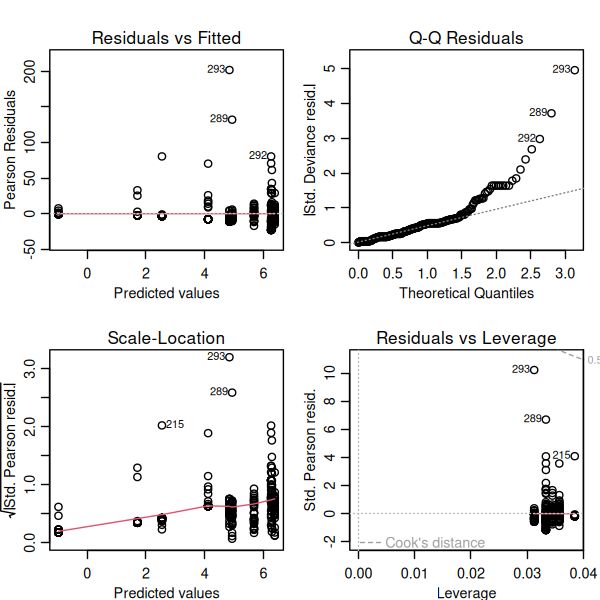

In [38]:
par(mfrow = c(2, 2), mar = c(3, 3, 3, 1), mgp = c(2, 0.8, 0))
plot(modQPois)    

The residuals and leverage plot is now ok. The Q-Q plot is not better, but is still an improvement over the original linear model. We can't improve the model fit any more — it isn't perfect but we'll accept those imperfections. It is worth thinking about the imperfections though — what might give rise to occasional larger than expected counts of
colonies?

We'll look at the `anova` table next. Technically, this is now analysis of deviance not analysis of variance but the concept is the same. Different tests are appropriate for different families of distribution, but we can use $F$ here:

In [39]:
anova(modQPois, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,293,134444.90,NA,NA
Strain,4,13923.431,289,120521.47,8.629323,1.383092e-06
Treatment,1,6054.662,288,114466.81,15.009988,1.328328e-04
Strain:Treatment,4,52887.715,284,61579.09,32.778214,1.790403e-22


Can we simplify the model? The interaction is the only term we can drop and looks highly significant, but we can check by deleting it.

In [40]:
drop.scope(modQPois)

[1] "Strain:Treatment"

In [41]:
modQPois2 <- update(modQPois, . ~ . - Strain:Treatment)
anova(modQPois, modQPois2, test = "F")

,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,284,61579.09,NA,NA,NA,NA
2,288,114466.81,-4,-52887.72,32.77821,1.790403e-22


No, that makes the model much worse, so we now have our final model.

$\star$ Include this new model fitting in your script and check you've got the same results.

### Model predictions

We can get model predictions and standard errors using the `predict` function. There is a difference though. glms use an internal transformation to model the data using a *link function* and the coefficients in the summary above are on the scale of the link transformation. The link function defines the relationship between the linear predictor and the mean of the distribution function, so that an otherwise non-linear (non-normal) response can be accommodated. For quasipoisson, the default is a *log link*, which you can see in the output of `anova`. You can use `predict` to get predictions on the scale of the original *response*. You can use different link functions than the "canonical" one encoded for each distribution `family`, but covering this is outside the scope of this chapter. 

In [42]:
# use expand.grid to get all combinations of factors
df <- expand.grid(Strain = levels(coloniesCN$Strain), Treatment = levels(coloniesCN$Treatment))

predict(modQPois, newdata = df, type = "response")

1          2          3          4          5          6          7 
538.200000 138.866667  12.730778   0.375000 126.687500  61.285714   5.517241 
         8          9         10 
292.714286 593.000000 523.900000

Those are the same values as the means we calculated for the barplot. Adding standard errors to barplots is more difficult for glms and we won't go into it here.

### reporting the model

reporting complicated statistics is a difficult business. There is a lot of detail involved and you want the reader to understand what you have done well enough to repeat the analysis if needed. You also have to summarise and explain the results without pages of r output.

Here are some pointers:

- What does the data show? Present a graph or a table to show the data you are about to model. *Always* include a figure or table legend and *always* refer to that figure or legend from the text.

- Have you transformed the data or used a subset? If so, why?

- What kind of model or statistical test have you used?

- With linear models, what is the response variable and what are the explanatory variables.

- Have you simplified the model and, if so, what was the most complex model you tried?

- How did you check the suitability of the model? Are there any problems with the model and, if so, what might cause them?

- If you summarise stats in text, you must include all the information about the test.
    - For $F$ tests, this is $F$, the two degrees of freedom and the p value. For example: 'There is a significant interaction between treatment and strain ($F_{4,284}=32.7, p < 0.0001$)'.
    - For $t$ tests, this is the coefficient, the standard error, $t$, the degrees of freedom and $p$. For example, 'Across strains, the main effect of nitroguanisine is to reduce colony counts relative to the control (estimate=-2.17, s.e= 0.51, $t=-4.26$, df=284, $p < 0.0001$)'.
    
- With more complex models, it is common to present either the anova table or the coefficients table as a summary of the model output. Just include the tables from R output, not the information around it. See Table 1 for an example.

- *Never* just include chunks of raw output from R.

- Most importantly, you need to convey what the interpretation of the model is. What is it telling you about the data?

*Table 1*: Coefficients from a GLM of treatment and strain as predictors of colony count.

|Estimate|   Std. Error|   t value |p |
|-:|:-|:-|:-|                
|(Intercept)|       6.29|         0.16|     39.78 |<0.0001|
|Strain712|-1.35 | 0.35|-3.88|0.0001|
|Strain881|      -3.74|         1.11|     -3.36| 0.0009|
|                  Strain899|      -7.27|         5.80|     -1.25| 0.2111|
|                StrainTA102|      -1.45|         0.35|     -4.10 |<0.0001|
|                TreatmentNG|      -2.17|         0.51|     -4.26| <0.0001|
|      Strain712:TreatmentNG|      -1.05|         1.70|     -0.62| 0.5353|
|      Strain881:TreatmentNG|       5.31|         1.24|      4.30| &lt;0.0001|
|Strain899:TreatmentNG|       9.54|         5.82|      1.64| 0.1025|
|    StrainTA102:TreatmentNG|       3.59|         0.62|      5.79| &lt;0.0001|
    

Halos and lawns
---------------

We'll keep this one simple since it is harder to analyse. The response variable (`HaloLawn`) is binary — the plates either have a lawn or not. We'll just look at a contingency table of how many plates have halos or lawns under each combination of treatment and strain.

In [43]:
table(Halo = colonies$HaloLawn, Strain = colonies$Strain, Treatment =  colonies$Treatment)

, , Treatment = Control

    Strain
Halo 421 712 881 899 TA102
   N   0   0   0   0     0
   Y   0   0   0   0     0

, , Treatment = His

    Strain
Halo 421 712 881 899 TA102
   N   1   1   0   0     1
   Y  29  29  26  32    31

, , Treatment = NG

    Strain
Halo 421 712 881 899 TA102
   N   0   0   0   0     0
   Y   0   0   0   0     0

, , Treatment = Strep

    Strain
Halo 421 712 881 899 TA102
   N   5  30   5  21     0
   Y  25   0  25   9    32


So, lawns and halos are never recorded from nitroguanisine or the control. They're nearly always found with histidine and different strains have different response to streptomysin. Again, treatment and strain interact. Although you can use a $\chi^2$ test with two-dimensional contingency tables to look for independence between factors, you can't with a three-way table without using more specialized tests. 

We will not go any further into this, but be aware that such gnarly statistical challenges may arise at times!  


[^fn1-c65]: Here you will work with the script file `glm.R`


